In [19]:
import json
import os
import re
from pathlib import Path
from collections import Counter

import anndata
import pandas as pd
import numpy as np
import tifffile
from einops import rearrange
from skimage.measure import regionprops

In [20]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%autoreload 2

In [22]:
import multiplex_imaging_pipeline.utils as utils
from multiplex_imaging_pipeline.spatial_features import DEFAULT_GATING_STRATEGY

In [23]:
output_dir = '/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1'
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [24]:
channel_thresholds = json.load(open(os.path.join(output_dir, 'channel_thresholds.json')))
channel_thresholds.keys(), next(iter(channel_thresholds.values()))

(dict_keys(['HT110B1_S1H4 | HT110B1_S1H4', 'HT171B1-S1H9A1-4_04192023 | HT171B1-S1H9A1-4_04192023', 'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'HT171B1-S1H9A1-A4_left_05262023 | HT171B1-S1H9A1-A4_left_05262023.ome.tiff', 'HT171B1-S1H9A1-A4_right_05262023 | HT171B1-S1H9A1-A4_right_05262023.ome.tiff', 'HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff', 'HT206B1-S1H5_U2_07012023 | HT206B1-S1H5_U2_07012023.ome.tiff', 'HT206B1_H1 | HT206B1_H1', 'HT206B1_H1_06252022 | HT206B1_H1_06252022', 'HT206B1_S1H2L4_20221020 | HT206B1_S1H2L4_20221020', 'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028', 'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023', 'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff', 'HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff', 'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff', 'HT243B1-S1

In [25]:
ome_fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan',
                                 regex=r'level_2/[^/]+.ome.tiff$'))
seg_fps = sorted(utils.listfiles('/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan',
                                 regex=r'level_3.*cell_seg.*.tif$'))

sample_to_ome = {fp.split('/')[-1].replace('.ome.tiff', '') + '_' + fp.split('/')[-3]:fp for fp in ome_fps}
sample_to_seg = {fp.split('/')[-1].replace('_cell_segmentation.tif', '') + '_' + fp.split('/')[-4]:fp for fp in seg_fps}

for sample in sorted(sample_to_ome.keys()):
    if sample in sample_to_ome and sample in sample_to_seg and re.findall(r'HT...B.', sample):
        ome_fp, seg_fp = sample_to_ome[sample], sample_to_seg[sample]
        print('{' + f"'img': '{ome_fp}', 'seg': '{seg_fp}'" + '},')


{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT110B1-S1H4_cell_segmentation.tif'},
{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1-S1H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_3/segmentation/HT171B1-S1H1A1_cell_segmentation.tif'},
{'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_2/HT171B1-S1H1A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/20221118_BRCA_HT271B1_S1H3A5_HT171B1_S1H1A1-A4/level_3/segmentation/HT171B1-S1H1A4_cell_segmentation.tif'},
{'img': '/diskmnt/Projec

In [26]:
mapping = {
    'HT110B1_S1H4 | HT110B1_S1H4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT110B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT110B1-S1H4_cell_segmentation.tif'},
    'HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT171B1-S1H9A1-4_left_05122023_cell_segmentation.tif'},
    'HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT171B1-S1H9A1-4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT171B1-S1H9A1-4_right_05122023_cell_segmentation.tif'},
    'HT171B1-S1H9A1-A4_left_05262023 | HT171B1-S1H9A1-A4_left_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT171B1-S1H9A1-A4_left_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT171B1-S1H9A1-A4_left_05262023_cell_segmentation.tif'},
    'HT171B1-S1H9A1-A4_right_05262023 | HT171B1-S1H9A1-A4_right_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT171B1-S1H9A1-A4_right_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT171B1-S1H9A1-A4_right_05262023_cell_segmentation.tif'},
    'HT206B1_H1 | HT206B1_H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_2/HT206B1-H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-H1/level_3/segmentation/HT206B1-H1_cell_segmentation.tif'},
    'HT206B1_H1_06252022 | HT206B1_H1_06252022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_2/HT206B1_H1_06252022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1_H1_06252022/level_3/segmentation/HT206B1_H1_06252022_cell_segmentation.tif'},
    'HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_2/HT206B1_S1H2L4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT206B1-S1H2L4_LRG_HT427P1_S1H1A3_SML_20221028/level_3/segmentation/HT206B1_S1H2L4_cell_segmentation.tif'},
    'HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT206B1-S1H5_U1_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT206B1-S1H5_U1_07012023_cell_segmentation.tif'},
    'HT206B1-S1H5_U2_07012023 | HT206B1-S1H5_U2_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT206B1-S1H5_U2_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT206B1-S1H5_U2_07012023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT243B1-S1H4A4_04192023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT243B1-S1H4A4_left_05122023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT243B1-S1H4A4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT243B1-S1H4A4_right_05122023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_left_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT243B1-S1H4A4_left_05262023_cell_segmentation.tif'},
    'HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT243B1-S1H4A4_right_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT243B1-S1H4A4_right_05262023_cell_segmentation.tif'},
    'HT243B1_S1H4 | HT243B1_S1H4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT243B1-S1H4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT243B1-S1H4_cell_segmentation.tif'},
    'HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT271B1-S1H6A5_04192023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT271B1-S1H6A5_left_05122023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT271B1-S1H6A5_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT271B1-S1H6A5_right_05122023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_left_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT271B1-S1H6A5_left_05262023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_mid_05262023 | HT271B1-S1H6A5_mid_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_mid_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT271B1-S1H6A5_mid_05262023_cell_segmentation.tif'},
    'HT271B1-S1H6A5_right_05262023 | HT271B1-S1H6A5_right_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT271B1-S1H6A5_right_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT271B1-S1H6A5_right_05262023_cell_segmentation.tif'},
    'HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_2/HT271B1_S1H3A5.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021723_BCRA_HT271B1_S1H3A5/level_3/segmentation/HT271B1_S1H3A5_cell_segmentation.tif'},
    'HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT297B1-S1H1_U1_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT297B1-S1H1_U1_07012023_cell_segmentation.tif'},
    'HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT297B1-S1H1_U2_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT297B1-S1H1_U2_07012023_cell_segmentation.tif'},
    'HT305B1_S1H1 | HT305B1_S1H1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_2/HT305B1-S1H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT243B1-S1H4_HT110B1-S1H4_HT305B1-S1H1/level_3/segmentation/HT305B1-S1H1_cell_segmentation.tif'},
    'HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT308B1-S1H5A4_04192023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT308B1-S1H5A4_04192023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_left_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT308B1-S1H5A4_left_05122023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_right_05122023 | HT308B1-S1H5A4_right_05122023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_2/HT308B1-S1H5A4_right_05122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4/level_3/segmentation/HT308B1-S1H5A4_right_05122023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT308B1-S1H5A4_left_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT308B1-S1H5A4_left_05262023_cell_segmentation.tif'},
    'HT308B1-S1H5A4_right_05262023 | HT308B1-S1H5A4_right_05262023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_2/HT308B1-S1H5A4_right_05262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/052623_HT171B1-S1H9A1-A4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm/level_3/segmentation/HT308B1-S1H5A4_right_05262023_cell_segmentation.tif'},
    'HT323B1_H1A1 | HT323B1_H1A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A1/level_2/HT323B1-H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A1/level_3/segmentation/HT323B1-H1A1_cell_segmentation.tif'},
    'HT323B1_H1A4 | HT323B1_H1A4': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A4/level_2/HT323B1-H1A4.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1A4/level_3/segmentation/HT323B1-H1A4_cell_segmentation.tif'},
    'HT323B1_H1_08042022 | HT323B1_H1_08042022': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1-08042022/level_2/HT323B1-H1-08042022.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H1-08042022/level_3/segmentation/HT323B1-H1-08042022_cell_segmentation.tif'},
    'HT323B1_H3 | HT323B1_H3': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H3/level_2/HT323B1-H3.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT323B1-H3/level_3/segmentation/HT323B1-H3_cell_segmentation.tif'},
    'HT339B1_H1A1 | HT339B1_H1A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H1A1/level_2/HT339B1-H1A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H1A1/level_3/segmentation/HT339B1-H1A1_cell_segmentation.tif'},
    'HT339B1_H2A1 | HT339B1_H2A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H2A1/level_2/HT339B1-H2A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT339B1-H2A1/level_3/segmentation/HT339B1-H2A1_cell_segmentation.tif'},
    'HT339B2-H2_U1_07012023 | HT339B2-H2_U1_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT339B2-H2_U1_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT339B2-H2_U1_07012023_cell_segmentation.tif'},
    'HT339B2-H2_U2_07012023 | HT339B2-H2_U2_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT339B2-H2_U2_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT339B2-H2_U2_07012023_cell_segmentation.tif'},
    'HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_2/HT365B1_S1H1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/021323_BRCA_HT365B1_S1H1/level_3/segmentation/HT365B1_S1H1_cell_segmentation.tif'},
    'HT397B1_H2A2 | HT397B1_H2A2': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H2A2/level_2/HT397B1-H2A2.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H2A2/level_3/segmentation/HT397B1-H2A2_cell_segmentation.tif'},
    'HT397B1_H3A1 | HT397B1_H3A1': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H3A1/level_2/HT397B1-H3A1.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT397B1-H3A1/level_3/segmentation/HT397B1-H3A1_cell_segmentation.tif'},
    'HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_2/HT397B1_S1H1A3U22_04122023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/041223_BRCA_HT397B1-S1H3A1-U22/level_3/segmentation/HT397B1_S1H1A3U22_04122023_cell_segmentation.tif'},
    'HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_2/HT397B1_S1H1A3U31_04062023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/040623_BRCA_HT397B1-U31/level_3/segmentation/HT397B1_S1H1A3U31_04062023_cell_segmentation.tif'},
    'HT397B1_U12_03172023 | HT397B1_U12_03172023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_3/segmentation/HT397B1_U12_03172023_cell_segmentation.tif'},
    'HT397B1_U2_03162023 | HT397B1_U2_03162023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/031623_BRCA_HT397B1-U2/level_3/segmentation/HT397B1_U2_03162023_cell_segmentation.tif'},
    'HT480B1_S1H2_R001 | HT480B1_S1H2_R001': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg001/level_2/HT480B1-S1H2-R001.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg001/level_3/segmentation/HT480B1-S1H2-R001_cell_segmentation.tif'},
    'HT480B1_S1H2_R002 | HT480B1_S1H2_R002': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg002/level_2/HT480B1-S1H2-R002.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/HT480B1-S1H2_reg002/level_3/segmentation/HT480B1-S1H2-R002_cell_segmentation.tif'},
    'HT565B1-H2_04262023 | HT565B1-H2_04262023': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_2/HT565B1-H2_04262023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM/level_3/segmentation/HT565B1-H2_04262023_cell_segmentation.tif'},
    'HT565B1-S1H2_U1_07012023 | HT565B1-S1H2_U1_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT565B1-S1H2_U1_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT565B1-S1H2_U1_07012023_cell_segmentation.tif'},
    'HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff': {'img': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_2/HT565B1-S1H2_U2_07012023.ome.tiff', 'seg': '/diskmnt/Projects/Users/estorrs/multiplex_data/codex/htan/brca/07012023_BRCA_HT206B1-S1H5_TOP_HT297B1-S1H1_HT339B2-H2_HT565B1-S1H2_BTTM/level_3/segmentation/HT565B1-S1H2_U2_07012023_cell_segmentation.tif'},
}


In [27]:
fps = [d['img'] for d in mapping.values()]
for sample, ome in sample_to_ome.items():
    if ome in fps:
        missing = utils.unconverted_channels(ome)
        print(sample, missing)

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/ome_types/_convenience.py:112: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


HT365B1_S1H1_021323_BRCA_HT365B1_S1H1 []
HT271B1_S1H3A5_021723_BCRA_HT271B1_S1H3A5 []
HT397B1_U2_03162023_031623_BRCA_HT397B1-U2 []
HT397B1_U12_03172023_03172023_BRCA_HT397B1-U12 []
HT397B1_S1H1A3U31_04062023_040623_BRCA_HT397B1-U31 []
HT397B1_S1H1A3U22_04122023_041223_BRCA_HT397B1-S1H3A1-U22 []
HT243B1-S1H4A4_04192023_041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm []
HT271B1-S1H6A5_04192023_041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm []
HT308B1-S1H5A4_04192023_041923_BRCA_HT171B1-S1H9A1-4_top_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4_btm []
HT565B1-H2_04262023_042623_MULTIPLE_HTAN_HT413C1-K2_TOP_HT339B2-H1_HT553P1-H2_HT565B1-H2_BTM []
HT171B1-S1H9A1-4_left_05122023_051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4 []
HT171B1-S1H9A1-4_right_05122023_051223_BRCA_HT171B1-S1H9A1-4_TOP_HT243B1-S1H4A4_HT271B1-S1H6A5_HT308B1-S1H5A4 []
HT243B1-S1H4A4_left_05122023_051223_BRCA_HT171B1-S1H9A1

In [28]:
def generate_feature_table(ome_fp, seg_fp, thresholds):
    print('extracting ome.tiff')
    channels, imgs = utils.extract_ome_tiff(ome_fp, as_dict=False)
    print(channels, imgs.shape)
    assert len(channels) == len(thresholds)
    
    seg = tifffile.imread(seg_fp)
    thresholds = np.asarray(thresholds) # make sure numpy
    
    masks = rearrange(
        rearrange(imgs, 'c h w -> h w c') > thresholds,
        'h w c -> c h w')
    
    props = regionprops(seg)
    print('num props', len(props))
    
    data = []
    for i, prop in enumerate(props):
        label = i + 1
        row = []
        r1, c1, r2, c2 = prop['bbox']

        area = prop['area']
        seg_tile = seg[r1:r2, c1:c2]
        imgs_tile = imgs[..., r1:r2, c1:c2]
        masks_tile = masks[..., r1:r2, c1:c2]

        cell_mask = seg_tile==label

        row = [label, prop['centroid'][0], prop['centroid'][1], r1, c1, r2, c2, area]
        for j in range(imgs_tile.shape[0]):
            img, mask = imgs_tile[j], masks_tile[j]
            counts = (cell_mask & mask).sum()
            row.append(counts / area)
            
            intensity = img[cell_mask].mean()
            row.append(intensity)

        data.append(row)

    cols = ['label', 'row', 'col', 'bbox-r1', 'bbox-c1', 'bbox-r2', 'bbox-c2', 'area']
    for c in channels:
        converted = utils.R_CHANNEL_MAPPING.get(c, c)
        for identifier in ['fraction', 'intensity']:
            cols.append(f'{converted}_{identifier}')
    df = pd.DataFrame(data=data, columns=cols)
    return df


In [29]:
name_to_features = {}
for name in mapping.keys():
    print(name)
    df = generate_feature_table(mapping[name]['img'], mapping[name]['seg'], channel_thresholds[name])
    name_to_features[name] = df

HT110B1_S1H4 | HT110B1_S1H4
extracting ome.tiff
['DAPI', 'CD8', 'CD138', 'CD4', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'Keratin 17', 'HLA-DR', 'GATA3-(D)', 'CD36-(D)', 'MGP-(D)', 'Keratin 14', 'SMA-(D)', 'CD68', 'CD20-(D)', 'Vimentin-(D)', 'CD3e', 'CD163', 'Ki67', 'PR-(D)', 'ER', 'P16-(D)', 'CK19', 'P21 (D)'] (26, 30000, 22760)
num props 77651
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff
extracting ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'TFF1', 'MGP-(D)', 'E-cadherin', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD11b (D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1'] (33, 12000, 15000)
num props 77098
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff
extracting ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-

['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin', 'CD68 (D)', 'HLA-DR', 'Keratin 14', 'TFF1', 'MGP-(D)', 'E-cadherin', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD11b (D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1'] (33, 17000, 16680)
num props 59028
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff
extracting ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'PanCK (D)', 'GLUT1-(D)', 'Podoplanin (D)', 'HLA-DR', 'CK14 (D)', 'TFF1', 'MGP-(D)', 'E-cadherin', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD11b (D)', 'PR-(D)', 'Bap1 (D)', 'CD45 (D)', 'ER', 'CD31', 'COX6c (D)', 'CK19', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4', 'CD4 (D)', 'SLC39A6', 'CD20', 'BCA1', 'CD163', 'CD68 (D)'] (34, 14000, 9000)
num props 33188
HT271B1-S1H6A5_mid_05262023 | HT271B1-S1H6A5_mid_05262023.ome.tiff
extracting ome.tiff
['DAPI', 'CD8', 

num props 128015
HT339B2-H2_U1_07012023 | HT339B2-H2_U1_07012023.ome.tiff
extracting ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin (D)', 'CD20', 'HLA-DR', 'CK14 (D)', 'TFF1', 'MGP-(D)', 'E-cadherin', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD31 (D)', 'PR-(D)', 'CD45 (D)', 'ER', 'COX6c (D)', 'Granzyme B', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4 (D)', 'CD4 (D)', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FoxP3', 'CD163', 'PD-1', 'HIF1A'] (37, 10000, 10000)
num props 11992
HT339B2-H2_U2_07012023 | HT339B2-H2_U2_07012023.ome.tiff
extracting ome.tiff
['DAPI', 'CD8', 'Her2 (D)', 'GATA3 (D)', 'cKIT-(D)', 'Pan-Cytokeratin', 'GLUT1-(D)', 'Podoplanin (D)', 'CD20', 'HLA-DR', 'CK14 (D)', 'TFF1', 'MGP-(D)', 'E-cadherin', 'SMA-(D)', 'CD3e', 'Ki67', 'Vimentin-(D)', 'CD31 (D)', 'PR-(D)', 'CD45 (D)', 'ER', 'COX6c (D)', 'Granzyme B', 'Keratin 5', 'PLAT/tPA (D)', 'CTLA4 (D)', 'CD4 (D)', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FoxP3', 'CD1

In [30]:
default = .05
brca_subtype_strategies = {
    'cKit': [
        {
            'name': 'epithelial - cKit positive',
            'strategy': [
                {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'},
                {'channel': 'cKit', 'value': default, 'direction': 'pos'},
            ],
        },
        {
            'name': 'epithelial - cKit positive',
            'strategy': [
                {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'},
                {'channel': 'cKit', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'GATA3': [
        {
            'name': 'epithelial - GATA3 positive',
            'strategy': [
                {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'},
                {'channel': 'GATA3', 'value': default, 'direction': 'pos'},
            ],
        },
        {
            'name': 'epithelial - GATA3 positive',
            'strategy': [
                {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'},
                {'channel': 'GATA3', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'CK14': [
        {
            'name': 'epithelial - CK14 positive',
            'strategy': [
                {'channel': 'CK14', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'CK19': [
        {
            'name': 'epithelial - CK19 positive',
            'strategy': [
                {'channel': 'CK19', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'PR': [
        {
            'name': 'epithelial - PR positive',
            'strategy': [
                {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'},
                {'channel': 'PR', 'value': default, 'direction': 'pos'},
            ],
        },
        {
            'name': 'epithelial - PR positive',
            'strategy': [
                {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'},
                {'channel': 'PR', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'ER': [
        {
            'name': 'epithelial - ER positive',
            'strategy': [
                {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'},
                {'channel': 'ER', 'value': default, 'direction': 'pos'},
            ],
        },
        {
            'name': 'epithelial - ER positive',
            'strategy': [
                {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'},
                {'channel': 'ER', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'Her2': [
        {
            'name': 'epithelial - Her2 positive',
            'strategy': [
                {'channel': 'Pan-Cytokeratin', 'value': default, 'direction': 'pos'},
                {'channel': 'Her2', 'value': default, 'direction': 'pos'},
            ],
        },
        {
            'name': 'epithelial - Her2 positive',
            'strategy': [
                {'channel': 'E-cadherin', 'value': default, 'direction': 'pos'},
                {'channel': 'Her2', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'CD8': [
        {
            'name': 'CD8 positive',
            'strategy': [
                {'channel': 'CD8', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'BCA1': [
        {
            'name': 'BCA1 positive',
            'strategy': [
                {'channel': 'BCA1', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'CTLA4': [
        {
            'name': 'CTLA4 positive',
            'strategy': [
                {'channel': 'CTLA4', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'CD68': [
        {
            'name': 'CD68 positive',
            'strategy': [
                {'channel': 'CD68', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'CD163': [
        {
            'name': 'CD163 positive',
            'strategy': [
                {'channel': 'CD163', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'Granzyme-B': [
        {
            'name': 'Granzyme-B positive',
            'strategy': [
                {'channel': 'Granzyme-B', 'value': default, 'direction': 'pos'},
            ],
        },
    ],
    'pan-immune': [{'name': 'immune', 'strategy': [{'channel': c, 'value': default, 'direction': 'pos'}]}
                   for c in ['CD45', 'CD3', 'CD4', 'CD20', 'CD68', 'CD163', 'Granzyme-B', 'CD8']],
}

In [31]:
def gate_cells(name, df, gating_strategy, col_name='cell_type'):
    markers = [c.replace('_fraction', '') for c in df.columns if '_fraction' in c]
    print(markers)
    cell_types = np.asarray(['Unlabeled'] * df.shape[0], dtype=object)
    for d in gating_strategy:
        is_valid = cell_types=='Unlabeled'
        mask = np.ones_like(cell_types, dtype=np.bool)
        for strategy in d['strategy']:
            channel, val = strategy['channel'], strategy['value']
            threshold = channel_thresholds[name][markers.index(channel)] if channel in markers else 0
            x = df[f'{channel}_fraction'].to_list()[0] if f'{channel}_fraction' in df.columns else 0
            print(name, threshold, x)
            if pd.isnull(x) or threshold==0:
                if len(d) == 1:
                    m = np.ones_like(mask, dtype=np.bool)
                else:
                    m = np.zeros_like(mask, dtype=np.bool)
            elif strategy['direction'] == 'pos': 
                m = df[f'{channel}_fraction'] >= val
            else:
                m = df[f'{channel}_fraction'] < val
            mask &= m

        if ~mask.sum() == 0: # if all true then pass bc that means marker isn't present or something is wrong with gate
            pass
        else:
            mask &= is_valid
            cell_types[mask] = d['name']
    df[col_name] = cell_types
    return df

In [32]:
for name, df in name_to_features.items():
    df = gate_cells(name, df, DEFAULT_GATING_STRATEGY, 'default_annotation')
    
    for k, gs in brca_subtype_strategies.items():
        df = gate_cells(name, df, gs, f'{k}_annotation')
    name_to_features[name] = df

['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'GATA3', 'CD36', 'MGP', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD3e', 'CD163', 'Ki67', 'PR', 'ER', 'P16', 'CK19', 'P21']
HT110B1_S1H4 | HT110B1_S1H4 10.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 11.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 12.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 10.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 19.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 0 0
HT110B1_S1H4 | HT110B1_S1H4 15.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 254.0 0.0
HT110B1_S1H4 | HT110B1_S1H4 19.0 0.0
HT110B1_S1H4 | H

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 15.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 212.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 14.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 0 0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 14.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 254.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 15.0 0.0
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff 212.0 0.0
HT171B1-S1H9A1-4_l

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 15.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 212.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 14.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 0 0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 14.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 10.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 254.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 15.0 0.0
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff 212.

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1', 'CD163', 'CD68']
HT171B1-S1H9A1-A4_left_05262023 | HT171B1-S1H9A1-A4_left_05262023.ome.tiff 254.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1', 'CD163', 'CD68']
HT171B1-S1H9A1-A4_left_05262023 | HT171B1-S1H9A1-A4_left_05262023.ome.tiff 254.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c',

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT206B1_H1 | HT206B1_H1 3162.0 0.0
HT206B1_H1 | HT206B1_H1 4499.0 0.0
HT206B1_H1 | HT206B1_H1 3640.0 0.0
HT206B1_H1 | HT206B1_H1 3162.0 0.0
HT206B1_H1 | HT206B1_H1 2683.0 0.0
HT206B1_H1 | HT206B1_H1 4500.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'MMP9', 'HLA-DR', 'CK14', 'CD11c', 'CD44']
HT206B1_H1 | HT206B1_H1 5075.0 0.0
HT206B1_H1 | HT206B1_H1 0 0
HT206B1_H1 | HT206B1_H1 0.0 1.0
HT206B1_H1 | HT206B1_H1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'MMP9', 'HLA-DR', 'CK14', 'CD11c', 'CD44']
HT206B1_H1 | HT206B1_H1 5075.0 0.0
HT206B1_H1 | HT206B1_H1 0.0 0.043478260869565216
HT206B1

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'MMP9', 'HLA-DR', 'CK14', 'CD11c', 'CD44']
HT206B1_H1 | HT206B1_H1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'MMP9', 'HLA-DR', 'CK14', 'CD11c', 'CD44']
HT206B1_H1 | HT206B1_H1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'MMP9', 'HLA-DR', 'CK14', 'CD11c', 'CD44']
HT206B1_H1 | HT206B1_H1 3640.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20',

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT206B1_H1_06252022 | HT206B1_H1_06252022 65534.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 1500.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 5000.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 3645.0 0.28125
HT206B1_H1_06252022 | HT206B1_H1_06252022 3645.0 0.28125
HT206B1_H1_06252022 | HT206B1_H1_06252022 2000.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 2000.0 0.525
HT206B1_H1_06252022 | HT206B1_H1_06252022 0 0
HT206B1_H1_06252022 | HT206B1_H1_06252022 2000.0 0.75
HT206B1_H1_06252022 | HT206B1_H1_06252022 5000.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 3645.0 0.28125
HT206B1_H1_06252022 | HT206B1_H1_06252022 2000.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 3000.0 0.0
HT206B1_H1_06252022 | HT206B1_H1_06252022 5999.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT206B1_H1_06252022 | HT206B1_H1_06252022 5000.0 0.31875
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c', 'FGFR3', 'GATA3']
HT206B1_H1_06252022 | HT206B1_H1_06252022 4000.0 0.0125
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c', 'FGFR3', 'GATA3']
HT206B1_H1_06252022 | HT206B1_H1_06252022 0.0 1.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c', 'FGFR3', 'GATA3']
HT206B1_H1_06252022 | HT206

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT206B1_H1_06252022 | HT206B1_H1_06252022 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c', 'FGFR3', 'GATA3']
HT206B1_H1_06252022 | HT206B1_H1_06252022 3645.0 0.28125
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c', 'FGFR3', 'GATA3']
HT206B1_H1_06252022 | HT206B1_H1_06252022 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c', 'FGFR3', 'GATA3']
HT206B1_H1_06252022 | HT206B1_H1_0

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 254.0 0.0
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 19.0 0.0
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 10.0 0.034482758620689655
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 19.0 0.17647058823529413
['DAPI', 'CK19', 'CD31', 'CD4', 'CD8', 'Pan-Cytokeratin', 'CD107A', 'Podoplanin', 'CK17', 'CD3e', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD11c', 'Ki67', 'HLA-DR', 'CD163', 'FOXP3']
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 50.0 0.0
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 0 0
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 0 0
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 0 0
['DAPI', 'CK19', 'CD31', 'CD4', 'CD8', 'Pan-Cytokeratin', 'CD107A', 'Podoplanin', 'CK17', 'CD3e', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD11c', 'Ki67', 'HLA-DR', 'CD163', 'FOXP3']
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 50.0 0.0
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028 0 0
HT206B1_S1H2L4_20221028 

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']
HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff 24.0 0.8993939393939394
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']
HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff 39.0 0.8993939393939394
HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff 0 0
HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff 19.0 0.8993939393939394
HT206B

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023 254.0 0.0
HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023 10.0 0.1937682570593963
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD68', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA', 'CTLA4', 'CD11b', 'SLC39A6', 'CD4']
HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023 10.0 0.1937682570593963
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD68', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA', 'CTLA4', 'CD11b', 'SLC39A6', 'CD4']
HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', '

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 0 0
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 14.0 1.0
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 0 0
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 0 0
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff 10.0 0.0009857672924627567
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1']
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 15.0 0.0
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff 2

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 12.0 0.265695067264574
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 0 0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 12.0 0.265695067264574
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 10.0 0.265695067264574
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 22.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_left_

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 10.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 12.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 254.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 10.0 0.0
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff 10.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP

HT243B1_S1H4 | HT243B1_S1H4 254.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 254.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 19.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 15.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 10.0 0.0
['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'GATA3', 'CD36', 'MGP', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD3e', 'CD163', 'Ki67', 'PR', 'ER', 'P16', 'CK19', 'P21']
HT243B1_S1H4 | HT243B1_S1H4 10.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 0.0 0.2931726907630522
HT243B1_S1H4 | HT243B1_S1H4 0 0
HT243B1_S1H4 | HT243B1_S1H4 0.0 0.2931726907630522
['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'GATA3', 'CD36', 'MGP', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD3e', 'CD163', 'Ki67', 'PR', 'ER', 'P16', 'CK19', 'P21']
HT243B1_S1H4 | HT243B1_S1H4 10.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 9.0 0.0
HT243B1_S1H4 | HT243B1_S1H4 0 0
HT243B1_S1H4 | HT243B1_S1H4 9.0 0.0
['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cyto

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 254.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 39.0 0.0032414910858995136
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 63.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 0 0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 39.0 0.0032414910858995136
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 63.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 39.0 0.0032414910858995136
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 10.0 0.1280388978930308
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 254.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 20.0 0.26499189627228525
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 254.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 74.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 74.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 0 0
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 19.0 0.0
HT271B1-S1H6A5_04192023 | HT271B1-S1H

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD68', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA', 'CTLA4', 'CD11b', 'SLC39A6', 'CD4']
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD68', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA', 'CTLA4', 'CD11b', 'SLC39A6', 'CD4']
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD68', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA', 'CTLA4', 'CD11b', 'SLC39A6', 'CD4']
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff 14.0 1.0
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff 0 0
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff 0 0
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff 10.0 0.946236559139785
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1']
HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff 15.0 0.4434907010014306
HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff 212.0 0.0
HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 10.0 0.10402855685874554
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 12.0 0.831718510963794
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 10.0 0.6868944416114228
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff 10.0 0.4604793472718001
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1', 'CD163', 'CD68']
HT271B

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1', 'CD163', 'CD68']
HT271B1-S1H6A5_right_05262023 | HT271B1-S1H6A5_right_05262023.ome.tiff 22.0 0.0
HT271B1-S1H6A5_right_05262023 | HT271B1-S1H6A5_right_05262023.ome.tiff 10.0 0.37155963302752293
HT271B1-S1H6A5_right_05262023 | HT271B1-S1H6A5_right_05262023.ome.tiff 254.0 0.0
HT271B1-S1H6A5_right_05262023 | HT271B1-S1H6A5_right_05262023.ome.tiff 10.0 0.37155963302752293
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1', 'CD163', 'CD68']
HT271B1-S1H6A5_right_05262023 | HT2

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 39.0 1.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 19.0 0.9291044776119403
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 39.0 1.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 1.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 0.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 0.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 0.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 0.9953358208955224
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 39.0 0.9664179104477612
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 39.0 1.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_070

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 0.9505597014925373
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 1.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 0.9505597014925373
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 15.0 0.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 10.0 1.0
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff 15.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'P

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 39.0 0.903883495145631
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 19.0 0.891747572815534
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 39.0 0.903883495145631
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.903883495145631
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 0.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 0.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 0.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.920873786407767
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 39.0 0.920388349514563
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 39.0 0.903883495

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.903883495145631
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 39.0 0.920388349514563
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 254.0 0.0
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.9111650485436893
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.903883495145631
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff 10.0 0.9111650485436893
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT305B1_S1H1 | HT305B1_S1H1 11.0 0.1541095890410959
HT305B1_S1H1 | HT305B1_S1H1 12.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 10.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 0 0
HT305B1_S1H1 | HT305B1_S1H1 254.0 0.0
HT305B1_S1H1 | HT305B1_S1H1 254.0 0.0
HT305B1_S1H1 | HT305B1_S1H1 19.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 0 0
HT305B1_S1H1 | HT305B1_S1H1 0 0
HT305B1_S1H1 | HT305B1_S1H1 15.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 254.0 0.0
HT305B1_S1H1 | HT305B1_S1H1 254.0 0.0
HT305B1_S1H1 | HT305B1_S1H1 19.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 15.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 10.0 0.17465753424657535
['DAPI', 'CD8', 'CD138', 'CD4', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'GATA3', 'CD36', 'MGP', 'CK14', 'SMA', 'CD68', 'CD20', 'Vimentin', 'CD3e', 'CD163', 'Ki67', 'PR', 'ER', 'P16', 'CK19', 'P21']
HT305B1_S1H1 | HT305B1_S1H1 10.0 0.17465753424657535
HT305B1_S1H1 | HT305B1_S1H1 10.0 0.174657534246575

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'CD20', 'BCA1']
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 15.0 0.0
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 212.0 0.0
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 10.0 0.2769367764915405
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 14.0 0.2769367764915405
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 0 0
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 10.0 0.2769367764915405
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 14.0 0.2769367764915405
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff 10.0 0.2769367764915405
HT308B1-

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 22.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 10.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 12.0 0.06772908366533864
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff 254.0 0.0
HT308B1-S1H5A4_left_05262023 | HT308B1-

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 4000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1750.0 0.11688311688311688
HT323B1_H1A1 | HT323B1_H1A1 2999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 2999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1750.0 0.11688311688311688
HT323B1_H1A1 | HT323B1_H1A1 2999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1750.0 0.11688311688311688
HT323B1_H1A1 | HT323B1_H1A1 2000.0 0.5064935064935064
HT323B1_H1A1 | HT323B1_H1A1 65534.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 4000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 2000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 0 0
HT323B1_H1A1 | HT323B1_H1A1 1750.0 0.11688311688311688
HT323B1_H1A1 | HT323B1_H1A1 2999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 2999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 3499.0 0.0
['DAPI', 'CD31', 'E-cadherin',

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT323B1_H1A1 | HT323B1_H1A1 0 0
HT323B1_H1A1 | HT323B1_H1A1 4000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 2000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 4000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A1 | HT323B1_H1A1 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokerat

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT323B1_H1A1 | HT323B1_H1A1 1000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A1 | HT323B1_H1A1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A1 | HT323B1_H1A1 0 0
HT323B1_H1A1 | HT323B1_H1A1 0 0
HT323B1_H1A1 | HT323B1_H1A1 2999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 65534.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1999.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 1000.0 0.0
HT323B1_H1A1 | HT323B1_H1A1 0 0
HT323B1_H1A1 | HT323B1_H1A1 2000.0 0.5064935064935

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT323B1_H1A4 | HT323B1_H1A4 2999.0 0.0
HT323B1_H1A4 | HT323B1_H1A4 1999.0 0.07547169811320754
HT323B1_H1A4 | HT323B1_H1A4 1000.0 0.0
HT323B1_H1A4 | HT323B1_H1A4 2999.0 0.0
HT323B1_H1A4 | HT323B1_H1A4 3499.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A4 | HT323B1_H1A4 1999.0 0.0
HT323B1_H1A4 | HT323B1_H1A4 0 0
HT323B1_H1A4 | HT323B1_H1A4 4000.0 0.0
HT323B1_H1A4 | HT323B1_H1A4 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A4 | HT323B

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT323B1_H1A4 | HT323B1_H1A4 1999.0 0.07547169811320754
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A4 | HT323B1_H1A4 1000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H1A4 | HT323B1_H1A4 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FO

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT323B1_H1_08042022 | HT323B1_H1_08042022 0 0
HT323B1_H1_08042022 | HT323B1_H1_08042022 4999.0 0.0
HT323B1_H1_08042022 | HT323B1_H1_08042022 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c']
HT323B1_H1_08042022 | HT323B1_H1_08042022 3000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c']
HT323B1_H1_08042022 | HT323B1_H1_08042022 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'CD36', 'ER', 'GLUT1', 'SMA', 'CK19', 'MGP', 'Vimentin', 'PR', 'FOXP3', 'CK17', 'cKit', 'HLA-DR', 'CK14', 'CD11c']


/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT323B1_H3 | HT323B1_H3 65534.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 4000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 65534.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 4000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 1200.0 0.0
HT323B1_H3 | HT323B1_H3 4000.0 0.0
HT323B1_H3 | HT323B1_H3 0 0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 4000.0 0.0
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 1200.0 0.0
HT323B1_H3 | HT323B1_H3 2000.0 0.0
HT323B1_H3 | HT323B1_H3 5499.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']


/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 0 0
HT323B1_H3 | HT323B1_H3 4000.0 0.0
HT323B1_H3 | HT323B1_H3 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H3 | HT323B1_H3 3000.0 0.0
HT323B1_H3 | HT323B1_H3 2000.0 0.0
HT323B1_H3 | HT323B1_H3 4000.0 0.0
HT323B1_H3 | HT323B1_H3 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H3 | HT323B1_H3 3000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', '

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT323B1_H3 | HT323B1_H3 3000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H3 | HT323B1_H3 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'CD44']
HT323B1_H3 | HT323B1_H3 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'C

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT339B1_H1A1 | HT339B1_H1A1 1250.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 0 0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'MGP', 'beta-integrin', 'Podoplanin', 'CD3e', 'CK17', 'HIF1A', 'GLUT1', 'GATA3', 'P63', 'Histone-H3-Pho', 'SMA', 'CK19', 'MLPH', 'Vimentin', 'Maspin', 'FOXP3', 'CD163', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'GP2', 'cKit', 'COX2', 'Lyve-1']
HT339B1_H1A1 | HT339B1_H1A1 1250.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 2000.0 0.0
HT339B1_H1A1 | HT339B1_H1A1 1500.0 0.0
['DAPI', 'CD31', 'E-

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT339B1_H2A1 | HT339B1_H2A1 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'MGP', 'beta-integrin', 'Podoplanin', 'CD3e', 'CK17', 'HIF1A', 'GLUT1', 'GATA3', 'P63', 'Histone-H3-Pho', 'SMA', 'CK19', 'MLPH', 'Vimentin', 'Maspin', 'FOXP3', 'CD163', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'GP2', 'cKit', 'COX2', 'Lyve-1']
HT339B1_H2A1 | HT339B1_H2A1 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'MGP', 'beta-integrin', 'Podoplanin', 'CD3e', 'CK17', 'HIF1A', 'GLUT1', 'GATA3', 'P63', 'Histone-H3-Pho', 'SMA', 'CK19', 'MLPH', 'Vimentin', 'Maspin', 'FOXP3', 'CD163', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'GP2', 'cKit', 'COX2', 'Lyve-1']
HT339B1_H2A1 | HT339B1_H2A1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'MGP', 'beta-integrin', 'Podoplanin', 'CD3e', 'CK17', 'HIF1A', 'GLUT1', 'GATA3', 'P63', 'Histone-H3-Pho', 'SMA', 'CK19', 'MLPH', 'Vimentin', 'Maspin', 'FO

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 10.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 35.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 45.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 45.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 75.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 19.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 45.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 10.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 10.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CK17', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'CD68', 'Ki67', 'Vimentin', 'CD3e', 'PR', 'CD45', 'ER', 'CK19']
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 35.0 

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 10.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 45.0 0.0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 0 0
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023 10.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H2A2 | HT397B1_H2A2 2500.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 5000.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 1500.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 4000.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 2500.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 1500.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 4000.0 0.0
HT397B1_H2A2 | 

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT397B1_H2A2 | HT397B1_H2A2 2000.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 4000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H2A2 | HT397B1_H2A2 2500.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 2000.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 5000.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H2A2 | HT397B1_H2A2 2500.0 0.0
HT397B1_H2A2 | HT397B1_H2A2 2000.

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H2A2 | HT397B1_H2A2 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H2A2 | HT397B1_H2A2 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT397B1_H3A1 | HT397B1_H3A1 2500.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 2000.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 5000.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 2000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H3A1 | HT397B1_H3A1 3000.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H3A1 | HT397B1_H3A1 0.0 1.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokera

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT397B1_H3A1 | HT397B1_H3A1 5000.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H3A1 | HT397B1_H3A1 2500.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 0 0
HT397B1_H3A1 | HT397B1_H3A1 5000.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H3A1 | HT397B1_H3A1 1500.0 0.010309278350515464
['DAPI', 'CD31', 'E-cadherin', 'CD4',

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

['DAPI', 'CD31', 'E-cadherin', 'CD4', 'CD20', 'Ki67', 'CD68', 'Pan-Cytokeratin', 'CD8', 'Histone-H3-Pho', 'CD163', 'Podoplanin', 'CD3e', 'beta-integrin', 'HIF1A', 'GLUT1', 'GATA3', 'CD45RO', 'CD45RA', 'SMA', 'CK19', 'MGP', 'Vimentin', 'Maspin', 'FOXP3', 'CK17', 'MMP9', 'HLA-DR', 'CD36', 'CK14', 'CD11c', 'cKit', 'COX2', 'MLPH', 'Lyve-1', 'CD44']
HT397B1_H3A1 | HT397B1_H3A1 0 0
HT397B1_H3A1 | HT397B1_H3A1 0 0
HT397B1_H3A1 | HT397B1_H3A1 4000.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 65534.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 4000.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 1250.0 0.0
HT397B1_H3A1 | HT397B1_H3A1 0 0
HT397B1_H3A1 | HT397B1_H3A1 1500.0 0.010309278350515464
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 18.0 0.0
HT397B1_S1H1A3U22_04122023 | HT

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 10.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 20.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 15.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 0 0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 254.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 0 0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 10.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 8.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 18.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 10.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 20.0 0.0
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 254.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', '

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023 10.0 0.04081632653061224
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023 50.0 0.0
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023 59.0 0.04081632653061224
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023 0 0
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023 59.0 0.04081632653061224
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT397B1_U12_03172023 | HT397B1_U12_03172023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U12_03172023 | HT397B1_U12_03172023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U12_03172023 | HT397B1_U12_03172023 254.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U12_03172023 | HT397B1_U12_03172023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'C

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT397B1_U2_03162023 | HT397B1_U2_03162023 254.0 0.0
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.6292134831460674
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.6292134831460674
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U2_03162023 | HT397B1_U2_03162023 46.0 0.14606741573033707
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.5842696629213483
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.5842696629213483
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U2_03162023 | HT397B1_U2_03162023 46.0 0.14606741573033707
HT397B1_

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT397B1_U2_03162023 | HT397B1_U2_03162023 15.0 0.3595505617977528
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U2_03162023 | HT397B1_U2_03162023 10.0 0.3595505617977528
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'FOXP3', 'MGP', 'CD20', 'SMA', 'Ki67', 'Vimentin', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'PLAT/tPA']
HT397B1_U2_03162023 | HT397B1_U2_03162023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT480B1_S1H2_R001 | HT480B1_S1H2_R001 0 0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 4000.0 0.0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 4000.0 0.0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 6000.0 0.09090909090909091
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 0 0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 2000.0 0.0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 8000.0 0.5454545454545454
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'Pan-Cytokeratin', 'cKit', 'Histone-H3-Pho', 'CK17', 'Podoplanin', 'CD3e', 'CD36', 'GATA3', 'GLUT1', 'SMA', 'CK14', 'MGP', 'Vimentin', 'CD20', 'CD11c', 'CD8', 'HLA-DR', 'Ki67', 'CD68', 'PR', 'FOXP3', 'ER', 'PD1', 'CK19', 'PDL1']
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 6000.0 0.0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 14999.0 0.0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 5000.0 0.0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 14999.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'Pan-Cytokeratin', 'cKit', 'Histone-H3-Pho', 'CK17', 'Podoplanin', 'CD3e', 'CD36', 'GATA3', 'GLUT1', 'SMA', 'CK14', 'MGP', 'Vimentin', 'C

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

HT480B1_S1H2_R001 | HT480B1_S1H2_R001 0 0
HT480B1_S1H2_R001 | HT480B1_S1H2_R001 3499.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'Pan-Cytokeratin', 'cKit', 'Histone-H3-Pho', 'CK17', 'Podoplanin', 'CD3e', 'CD36', 'GATA3', 'GLUT1', 'SMA', 'CK14', 'MGP', 'Vimentin', 'CD20', 'CD11c', 'CD8', 'HLA-DR', 'Ki67', 'CD68', 'PR', 'FOXP3', 'ER', 'PD1', 'CK19', 'PDL1']
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 6000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 5000.0 1.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 4000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 4000.0 0.045454545454545456
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 65534.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 4000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 4000.0 0.045454545454545456
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 4000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 3499.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 4000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 6000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 5000.0 1.0
HT480B1_S1H2_R002 |

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT480B1_S1H2_R002 | HT480B1_S1H2_R002 20000.0 0.045454545454545456
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'Pan-Cytokeratin', 'cKit', 'Histone-H3-Pho', 'CK17', 'Podoplanin', 'CD3e', 'CD36', 'GATA3', 'GLUT1', 'SMA', 'CK14', 'MGP', 'Vimentin', 'CD20', 'CD11c', 'CD8', 'HLA-DR', 'Ki67', 'CD68', 'PR', 'FOXP3', 'ER', 'PD1', 'CK19', 'PDL1']
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 6000.0 0.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 0 0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 5000.0 1.0
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 0 0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'Pan-Cytokeratin', 'cKit', 'Histone-H3-Pho', 'CK17', 'Podoplanin', 'CD3e', 'CD36', 'GATA3', 'GLUT1', 'SMA', 'CK14', 'MGP', 'Vimentin', 'CD20', 'CD11c', 'CD8', 'HLA-DR', 'Ki67', 'CD68', 'PR', 'FOXP3', 'ER', 'PD1', 'CK19', 'PDL1']
HT480B1_S1H2_R002 | HT480B1_S1H2_R002 3499.0 0.0
['DAPI', 'CD31', 'E-cadherin', 'CD4', 'Pan-Cytokeratin', 'cKit', 'Histone-H3-Pho', 'CK17', 'Podoplanin', 'CD3e', 'CD36', 'GATA3', 'GLUT1', 'SMA', 'CK14', 'MGP', 'Viment

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

HT565B1-H2_04262023 | HT565B1-H2_04262023 12.0 0.021352313167259787
HT565B1-H2_04262023 | HT565B1-H2_04262023 10.0 0.0
HT565B1-H2_04262023 | HT565B1-H2_04262023 0 0
HT565B1-H2_04262023 | HT565B1-H2_04262023 10.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'a-Amylase', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK17', 'PLAT/tPA', 'CTLA4', 'Hep-Par-1', 'CD4', 'SLC39A6', 'CK5']
HT565B1-H2_04262023 | HT565B1-H2_04262023 10.0 0.0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD68', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'a-Amylase', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD11b', 'PR', 'Bap1', 'CD45', 'ER', 'CD31', 'COX6c', 'CK19', 'CK17', 'PLAT/tPA', 'CTLA4', 'Hep-Par-1', 'CD4', 'SLC39A6', 'CK5']
HT565B1-H2_04262023 | HT565B1-H2_04262023 0 0
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'C

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt

['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']
HT565B1-S1H2_U1_07012023 | HT565B1-S1H2_U1_07012023.ome.tiff 254.0 0.0
HT565B1-S1H2_U1_07012023 | HT565B1-S1H2_U1_07012023.ome.tiff 39.0 0.2450630502022365
HT565B1-S1H2_U1_07012023 | HT565B1-S1H2_U1_07012023.ome.tiff 10.0 0.46133714013799665
HT565B1-S1H2_U1_07012023 | HT565B1-S1H2_U1_07012023.ome.tiff 39.0 0.2450630502022365
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projec

HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 39.0 0.15584415584415584
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 39.0 0.15584415584415584
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 19.0 0.15584415584415584
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 0.0 0.0
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 0.0 0.0
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 10.0 0.15584415584415584
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 10.0 0.15584415584415584
['DAPI', 'CD8', 'Her2', 'GATA3', 'cKit', 'Pan-Cytokeratin', 'GLUT1', 'Podoplanin', 'CD20', 'HLA-DR', 'CK14', 'TFF1', 'MGP', 'E-cadherin', 'SMA', 'CD3e', 'Ki67', 'Vimentin', 'CD31', 'PR', 'CD45', 'ER', 'COX6c', 'Granzyme-B', 'CK5', 'PLAT/tPA', 'CTLA4', 'CD4', 'SLC39A6', 'TCF-1', 'BCA1', 'CD68', 'CD39', 'FOXP3', 'CD163', 'PD1', 'HIF1A']
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff 254.0 0.0
HT565B1-S1H2_U2_07012023

/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ones_like(cell_types, dtype=np.bool)
/diskmnt/Projects/Users/estorrs/sandbox/tmp/ipykernel_160309/4191935402.py:17: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  m = np.zeros_like(mask, dtype=np.bool)
/diskmnt/Projec

In [33]:
next(iter(name_to_features.values()))

,label,row,col,bbox-r1,bbox-c1,bbox-r2,bbox-c2,area,DAPI_fraction,DAPI_intensity,...,PR_annotation,ER_annotation,Her2_annotation,CD8_annotation,BCA1_annotation,CTLA4_annotation,CD68_annotation,CD163_annotation,Granzyme-B_annotation,pan-immune_annotation
0,1,17.990385,17704.975962,10,17696,27,17715,208,1.000000,7.331731,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled
1,2,834.043478,16233.826087,827,16227,843,16242,184,1.000000,7.309783,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled
2,3,869.718232,8363.696133,856,8359,880,8372,181,0.955801,4.193370,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled
3,4,12403.630252,3567.058824,12396,3559,12416,3582,238,0.768908,3.659664,...,Unlabeled,epithelial - ER positive,Unlabeled,CD8 positive,Unlabeled,Unlabeled,Unlabeled,CD163 positive,Unlabeled,immune
4,5,13123.575221,2606.977876,13117,2599,13135,2622,226,0.774336,3.738938,...,Unlabeled,epithelial - ER positive,Unlabeled,CD8 positive,Unlabeled,Unlabeled,Unlabeled,CD163 positive,Unlabeled,immune
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77646,77647,25673.460905,13995.358025,25663,13988,25685,14003,243,1.000000,19.041152,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled
77647,77648,25748.090196,4704.062745,25739,4695,25757,4715,255,1.000000,6.850980,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled
77648,77649,26070.784314,3563.771242,26059,3559,26080,3571,153,0.973856,4.287582,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled
77649,77650,26790.333333,4523.341270,26779,4520,26800,4530,126,1.000000,4.357143,...,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled,Unlabeled


(841.4598975752508, 18508.0005360129, -1326.708905677656, 28256.67548076923)

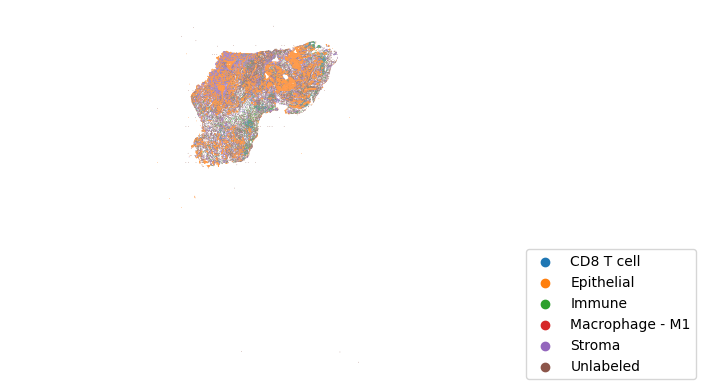

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
name = next(iter(name_to_features.keys()))
f = name_to_features[name]
order = sorted(set(f['default_annotation']))
sns.scatterplot(data=f, x='col', y='row', hue='default_annotation', s=.2, hue_order=order)
plt.legend(loc=(1.04, 0))
plt.axis('equal')
plt.axis('off')

In [35]:
for name, f in name_to_features.items():
    print(name)    
    val_cols = [c for c in f.columns if '_fraction' in c]
    meta = f[[c for c in f.columns if c not in val_cols]]
    meta = meta.set_index('label')
    a = anndata.AnnData(X=f[val_cols].values.astype(np.float32), obs=meta)
    a.var.index = val_cols
    
    a.uns['thresholds'] = channel_thresholds[name]
    a.uns['gating_strategy'] = json.dumps(DEFAULT_GATING_STRATEGY)
    
    a.obsm['spatial'] = meta[['col', 'row']].values
    
    root = os.path.join(output_dir, 'spatial_features')
    Path(root).mkdir(parents=True, exist_ok=True)
    
    identifier = name.split(' | ')[-1].replace('.ome.tiff', '')
    a.write_h5ad(os.path.join(root, f'{identifier}.h5ad'))
    f.to_csv(os.path.join(root, f'{identifier}.txt'), sep='\t')
    
    print(os.path.join(root, f'{identifier}.h5ad'))
    

HT110B1_S1H4 | HT110B1_S1H4


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT110B1_S1H4.h5ad
HT171B1-S1H9A1-4_left_05122023 | HT171B1-S1H9A1-4_left_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT171B1-S1H9A1-4_left_05122023.h5ad
HT171B1-S1H9A1-4_right_05122023 | HT171B1-S1H9A1-4_right_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT171B1-S1H9A1-4_right_05122023.h5ad
HT171B1-S1H9A1-A4_left_05262023 | HT171B1-S1H9A1-A4_left_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT171B1-S1H9A1-A4_left_05262023.h5ad
HT171B1-S1H9A1-A4_right_05262023 | HT171B1-S1H9A1-A4_right_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT171B1-S1H9A1-A4_right_05262023.h5ad
HT206B1_H1 | HT206B1_H1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT206B1_H1.h5ad
HT206B1_H1_06252022 | HT206B1_H1_06252022


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT206B1_H1_06252022.h5ad
HT206B1_S1H2L4_20221028 | HT206B1_S1H2L4_20221028


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT206B1_S1H2L4_20221028.h5ad
HT206B1-S1H5_U1_07012023 | HT206B1-S1H5_U1_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT206B1-S1H5_U1_07012023.h5ad
HT206B1-S1H5_U2_07012023 | HT206B1-S1H5_U2_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT206B1-S1H5_U2_07012023.h5ad
HT243B1-S1H4A4_04192023 | HT243B1-S1H4A4_04192023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT243B1-S1H4A4_04192023.h5ad
HT243B1-S1H4A4_left_05122023 | HT243B1-S1H4A4_left_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT243B1-S1H4A4_left_05122023.h5ad
HT243B1-S1H4A4_right_05122023 | HT243B1-S1H4A4_right_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT243B1-S1H4A4_right_05122023.h5ad
HT243B1-S1H4A4_left_05262023 | HT243B1-S1H4A4_left_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT243B1-S1H4A4_left_05262023.h5ad
HT243B1-S1H4A4_right_05262023 | HT243B1-S1H4A4_right_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT243B1-S1H4A4_right_05262023.h5ad
HT243B1_S1H4 | HT243B1_S1H4


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT243B1_S1H4.h5ad
HT271B1-S1H6A5_04192023 | HT271B1-S1H6A5_04192023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1-S1H6A5_04192023.h5ad
HT271B1-S1H6A5_left_05122023 | HT271B1-S1H6A5_left_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1-S1H6A5_left_05122023.h5ad
HT271B1-S1H6A5_right_05122023 | HT271B1-S1H6A5_right_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1-S1H6A5_right_05122023.h5ad
HT271B1-S1H6A5_left_05262023 | HT271B1-S1H6A5_left_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1-S1H6A5_left_05262023.h5ad
HT271B1-S1H6A5_mid_05262023 | HT271B1-S1H6A5_mid_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1-S1H6A5_mid_05262023.h5ad
HT271B1-S1H6A5_right_05262023 | HT271B1-S1H6A5_right_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1-S1H6A5_right_05262023.h5ad
HT271B1_S1H3A5_02172023 | HT271B1_S1H3A5_02172023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT271B1_S1H3A5_02172023.h5ad
HT297B1-S1H1_U1_07012023 | HT297B1-S1H1_U1_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT297B1-S1H1_U1_07012023.h5ad
HT297B1-S1H1_U2_07012023 | HT297B1-S1H1_U2_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT297B1-S1H1_U2_07012023.h5ad
HT305B1_S1H1 | HT305B1_S1H1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT305B1_S1H1.h5ad
HT308B1-S1H5A4_04192023 | HT308B1-S1H5A4_04192023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT308B1-S1H5A4_04192023.h5ad
HT308B1-S1H5A4_left_05122023 | HT308B1-S1H5A4_left_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT308B1-S1H5A4_left_05122023.h5ad
HT308B1-S1H5A4_right_05122023 | HT308B1-S1H5A4_right_05122023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT308B1-S1H5A4_right_05122023.h5ad
HT308B1-S1H5A4_left_05262023 | HT308B1-S1H5A4_left_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT308B1-S1H5A4_left_05262023.h5ad
HT308B1-S1H5A4_right_05262023 | HT308B1-S1H5A4_right_05262023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT308B1-S1H5A4_right_05262023.h5ad
HT323B1_H1A1 | HT323B1_H1A1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT323B1_H1A1.h5ad
HT323B1_H1A4 | HT323B1_H1A4


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT323B1_H1A4.h5ad
HT323B1_H1_08042022 | HT323B1_H1_08042022


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT323B1_H1_08042022.h5ad
HT323B1_H3 | HT323B1_H3


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT323B1_H3.h5ad
HT339B1_H1A1 | HT339B1_H1A1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT339B1_H1A1.h5ad
HT339B1_H2A1 | HT339B1_H2A1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT339B1_H2A1.h5ad
HT339B2-H2_U1_07012023 | HT339B2-H2_U1_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT339B2-H2_U1_07012023.h5ad
HT339B2-H2_U2_07012023 | HT339B2-H2_U2_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT339B2-H2_U2_07012023.h5ad
HT365B1_S1H1_02132023 | HT365B1_S1H1_02132023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT365B1_S1H1_02132023.h5ad
HT397B1_H2A2 | HT397B1_H2A2


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT397B1_H2A2.h5ad
HT397B1_H3A1 | HT397B1_H3A1


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT397B1_H3A1.h5ad
HT397B1_S1H1A3U22_04122023 | HT397B1_S1H1A3U22_04122023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT397B1_S1H1A3U22_04122023.h5ad
HT397B1_S1H1A3U31_04062023 | HT397B1_S1H1A3U31_04062023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT397B1_S1H1A3U31_04062023.h5ad
HT397B1_U12_03172023 | HT397B1_U12_03172023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT397B1_U12_03172023.h5ad
HT397B1_U2_03162023 | HT397B1_U2_03162023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT397B1_U2_03162023.h5ad
HT480B1_S1H2_R001 | HT480B1_S1H2_R001


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT480B1_S1H2_R001.h5ad
HT480B1_S1H2_R002 | HT480B1_S1H2_R002


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT480B1_S1H2_R002.h5ad
HT565B1-H2_04262023 | HT565B1-H2_04262023


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT565B1-H2_04262023.h5ad
HT565B1-S1H2_U1_07012023 | HT565B1-S1H2_U1_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT565B1-S1H2_U1_07012023.h5ad
HT565B1-S1H2_U2_07012023 | HT565B1-S1H2_U2_07012023.ome.tiff


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mip/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


/diskmnt/Projects/Users/estorrs/imaging-analysis/results/brca_subtype/revision_v1/spatial_features/HT565B1-S1H2_U2_07012023.h5ad


In [18]:
1

1